In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
# mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

## variables

In [5]:
data_dir = "../../../data/02__mpra/02__activs"
alpha_f = "%s/alpha_per_elem.quantification.txt" % data_dir
human_vals_f = "%s/human_TSS_vals.both_tiles.txt" % data_dir
mouse_vals_f= "%s/mouse_TSS_vals.both_tiles.txt" % data_dir

In [6]:
native_f = "%s/native_results.txt" % data_dir
HUES64_cis_f = "%s/HUES64_cis_results.txt" % data_dir
mESC_cis_f = "%s/mESC_cis_results.txt" % data_dir
human_trans_f = "%s/human_trans_results.txt" % data_dir
mouse_trans_f = "%s/mouse_trans_results.txt" % data_dir
cis_trans_int_f = "%s/cis_trans_interaction_results.txt" % data_dir

In [7]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.UPDATED_WITH_DIV.txt"

In [8]:
#align_f = "../../../misc/00__tss_metadata/tss_map.seq_alignment.txt"

In [9]:
#cage_data_f = "../../../misc/00__tss_metadata/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt.gz"

## 1. import data

In [10]:
alpha = pd.read_table(alpha_f, sep="\t").reset_index()
alpha.head()

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj
0,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...,7.295239,6.315911,2.825214e-75,1.383066e-42,4.596852e-74,1.878236e-41
1,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,1.326796,1.348824,1.451021e-01,2.326515e-01,3.319934e-01,5.455262e-01
2,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...,0.977164,1.548916,4.814953e-01,1.057092e-01,7.164347e-01,3.127558e-01
3,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...,0.976127,0.818171,4.826910e-01,7.414048e-01,7.167637e-01,8.145300e-01
4,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,1.323999,1.457128,1.469545e-01,1.559242e-01,3.356231e-01,4.172106e-01


In [11]:
len(alpha)

13879

In [12]:
human_vals = pd.read_table(human_vals_f)
mouse_vals = pd.read_table(mouse_vals_f)
human_vals.head()

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,...,dupe_info,HUES64_log,mESC_log,tss_id,species,tss_tile_num,hg19_id,biotype_hg19,stem_exp_hg19,orig_species
0,1.326796,1.348824,0.145102,0.232651,0.331993,0.545526,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,WILDTYPE,HUMAN_EVO_TSS__h.1133__tile1:129255098-1292552...,HUMAN_EVO_TSS__h.1133__tile1,...,7281.1.0.0,0.122804,0.129955,h.1133,HUMAN,tile1,h.1133,enhancer,0.20306,human
1,1.202075,1.503351,0.242922,0.128950,0.488166,0.364500,CTACTCCGGAGGCTGAGGCAGGAGAATCGCTTGAACCCGGGGGTGG...,WILDTYPE,HUMAN_EVO_TSS__h.1133__tile2:129255212-1292553...,HUMAN_EVO_TSS__h.1133__tile2,...,7282.1.0.0,0.079932,0.177061,h.1133,HUMAN,tile2,h.1133,enhancer,0.20306,human
2,1.326796,1.348824,0.145102,0.232651,0.331993,0.545526,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,WILDTYPE,HUMAN_EVO_TSS__h.1133__tile1:129255098-1292552...,HUMAN_EVO_TSS__h.1133__tile1,...,7281.1.0.0,0.122804,0.129955,h.1133,HUMAN,tile1,h.1133,enhancer,0.20306,human
3,1.202075,1.503351,0.242922,0.128950,0.488166,0.364500,CTACTCCGGAGGCTGAGGCAGGAGAATCGCTTGAACCCGGGGGTGG...,WILDTYPE,HUMAN_EVO_TSS__h.1133__tile2:129255212-1292553...,HUMAN_EVO_TSS__h.1133__tile2,...,7282.1.0.0,0.079932,0.177061,h.1133,HUMAN,tile2,h.1133,enhancer,0.20306,human
4,1.323999,1.457128,0.146955,0.155924,0.335623,0.417211,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,WILDTYPE,HUMAN_EVO_TSS__h.1436__tile1:157192113-1571922...,HUMAN_EVO_TSS__h.1436__tile1,...,4134.1.0.0,0.121888,0.163498,h.1436,HUMAN,tile1,h.1436,enhancer,0.039043800000000004,human


In [13]:
native = pd.read_table(native_f).reset_index()
native.columns = ["index", "stat_native", "pval_native", "fdr_native", "df.test_native", "df.dna_native", 
                  "df.rna.full_native", "df.rna.red_native", "logFC_native"]
native["index"] = native.apply(fix_ctrl_id, axis=1)
native.sample(5)

,index,stat_native,pval_native,fdr_native,df.test_native,df.dna_native,df.rna.full_native,df.rna.red_native,logFC_native
4898,h.2900__no cage activity__m.2711__div_lnc__tile2,22.302956,2.328479e-06,1.137978e-05,1,14,5,4,-1.233448
3861,h.1548__antisense__m.1360__no cage activity__t...,10.390287,1.266799e-03,3.269587e-03,1,14,5,4,0.772078
4268,h.2103__other_lnc__m.1915__no cage activity__t...,4.916243,2.660531e-02,4.787483e-02,1,14,5,4,0.643995
637,h.944__div_pc__m.827__unassigned__tile1,46.426138,9.513791e-12,1.520647e-10,1,14,5,4,1.657177
5514,ctrl.1__CONTROL__samp.65__CONTROL,4.050311,4.416321e-02,7.443987e-02,1,14,5,4,0.315304


In [14]:
HUES64_cis = pd.read_table(HUES64_cis_f).reset_index()
HUES64_cis.columns = ["index", "stat_cis_HUES64", "pval_cis_HUES64", "fdr_cis_HUES64", "df.test_cis_HUES64", 
                      "df.dna_cis_HUES64", "df.rna.full_cis_HUES64", "df.rna.red_cis_HUES64", "logFC_cis_HUES64"]
HUES64_cis["index"] = HUES64_cis.apply(fix_ctrl_id, axis=1)

mESC_cis = pd.read_table(mESC_cis_f).reset_index()
mESC_cis.columns = ["index", "stat_cis_mESC", "pval_cis_mESC", "fdr_cis_mESC", "df.test_cis_mESC", 
                    "df.dna_cis_mESC", "df.rna.full_cis_mESC", "df.rna.red_cis_mESC", "logFC_cis_mESC"]
mESC_cis["index"] = mESC_cis.apply(fix_ctrl_id, axis=1)

In [15]:
human_trans = pd.read_table(human_trans_f).reset_index()
human_trans.columns = ["index", "stat_trans_human", "pval_trans_human", "fdr_trans_human", "df.test_trans_human", 
                       "df.dna_trans_human", "df.rna.full_trans_human", "df.rna.red_trans_human", "logFC_trans_human"]
human_trans["index"] = human_trans.apply(fix_ctrl_id, axis=1)

mouse_trans = pd.read_table(mouse_trans_f).reset_index()
mouse_trans.columns = ["index", "stat_trans_mouse", "pval_trans_mouse", "fdr_trans_mouse", "df.test_trans_mouse", 
                       "df.dna_trans_mouse", "df.rna.full_trans_mouse", "df.rna.red_trans_mouse", "logFC_trans_mouse"]
mouse_trans["index"] = mouse_trans.apply(fix_ctrl_id, axis=1)

In [16]:
cis_trans_int = pd.read_table(cis_trans_int_f).reset_index()
cis_trans_int.columns = ["index", "stat_int", "pval_int", "fdr_int", "df.test_int", 
                         "df.dna_int", "df.rna.full_int", "df.rna.red_int", "logFC_int"]
cis_trans_int["index"] = cis_trans_int.apply(fix_ctrl_id, axis=1)

In [17]:
tss_map = pd.read_table(tss_map_f)
tss_map.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,har,orig_species,lift_species,oligo_type,hg19_id,mm9_id,cleaner_biotype_hg19,cleaner_biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,False,human,mouse,human__divergent:mouse__divergent,h.2,m.1,div. lncRNA,div. lncRNA,lncRNA,lncRNA
1,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,False,human,mouse,human__divergent:mouse__antisense,h.3,m.2,div. lncRNA,other lncRNA,lncRNA,lncRNA
2,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,False,human,mouse,human__antisense:mouse__protein_coding,h.4,m.3,other lncRNA,mRNA,lncRNA,mRNA
3,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,False,human,mouse,human__intergenic:mouse__intergenic,h.5,m.4,lincRNA,other lncRNA,lncRNA,lncRNA
4,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,False,human,mouse,human__intergenic:mouse__intergenic,h.6,m.4,lincRNA,other lncRNA,lncRNA,lncRNA


In [18]:
tss_map.biotype_hg19.value_counts()

enhancer            1093
no cage activity     872
protein_coding       311
intergenic           270
div_lnc              262
div_pc               253
antisense            156
intergenic_upep       74
antisense_upep        67
unassigned            51
other_lnc             28
other_pc              25
other_upep             3
multi-mapped           2
Name: biotype_hg19, dtype: int64

In [19]:
# align = pd.read_table(align_f, sep=",", index_col=0)
# align.head()

In [20]:
# cage_data = pd.read_table(cage_data_f, sep="\t")
# cage_data.drop(["tissue_sp_3", "n_expr"], axis=1, inplace=True)
# cage_data.columns = ["cage_id_hg19", "av_cage_exp_hg19", "cage_tissue_sp_hg19", "cage_tss_type_hg19"]
# cage_data.head()

## 2. add clean biotypes / biotype switch to TSS map

In [21]:
tss_map.minimal_biotype_hg19.value_counts()

eRNA                        1093
lncRNA                       860
mRNA                         589
reclassified - CAGE peak     529
no CAGE activity             343
other                         53
Name: minimal_biotype_hg19, dtype: int64

In [22]:
tss_map["biotype_switch_clean"] = tss_map.apply(biotype_switch_clean, axis=1)
tss_map.biotype_switch_clean.value_counts()

reclassified                    1067
eRNA                             700
biotype switch                   505
CAGE turnover - eRNA             468
mRNA                             158
CAGE turnover - lincRNA          147
CAGE turnover - other lncRNA      98
div. mRNA                         86
div. lncRNA                       67
other lncRNA                      38
CAGE turnover - div. lncRNA       37
other                             32
CAGE turnover - mRNA              23
lincRNA                           22
CAGE turnover - div. mRNA         15
CAGE turnover - other mRNA         2
other mRNA                         2
Name: biotype_switch_clean, dtype: int64

In [23]:
len(tss_map)

3467

In [24]:
tss_map["biotype_switch_minimal"] = tss_map.apply(biotype_switch_minimal, axis=1)
tss_map.biotype_switch_minimal.value_counts()

reclassified              1067
eRNA                       700
CAGE turnover - eRNA       468
mRNA                       415
biotype switch             297
CAGE turnover - lncRNA     282
lncRNA                     166
CAGE turnover - mRNA        40
other                       32
Name: biotype_switch_minimal, dtype: int64

## 3. merge alphas with TSS map

split up into tile1 and tile2

In [25]:
human_vals_sub = human_vals[["element", "tss_id", "tss_tile_num"]]
human_vals_sub.columns = ["hg19_element", "hg19_id", "hg19_tile_num"]

mouse_vals_sub = mouse_vals[["element", "tss_id", "tss_tile_num"]]
mouse_vals_sub.columns = ["mm9_element", "mm9_id", "mm9_tile_num"]
mouse_vals_sub.sample(5)

,mm9_element,mm9_id,mm9_tile_num
3793,CCGCCCGCGCAGATGACTGGCGAGCTGGCCGGCATGGGCTGGTACG...,m.122,tile1
2160,TTGTCTTTTTTTTTTTTTTTCCTAATCATGTGGACATCTCTGAGAA...,m.2927,tile1
3283,TGCAGCCGTGCTCTGCGTCCGCGAGACACATTAACTTCGTGGTGAC...,m.272,tile2
2267,GGCCTGTGAGGTGGGAGCGGTTGGCCTGCTGGCCTCGCTGCTTGGC...,m.2608,tile1
3890,CTCGAAGGCCACTCCAGAGGAGATCCAGGCTCTGATGTTTCTAAAA...,m.2177,tile2


In [26]:
human_vals_tile1 = human_vals_sub[human_vals_sub["hg19_tile_num"] == "tile1"].drop_duplicates()
human_vals_tile2 = human_vals_sub[human_vals_sub["hg19_tile_num"] == "tile2"].drop_duplicates()
mouse_vals_tile1 = mouse_vals_sub[mouse_vals_sub["mm9_tile_num"] == "tile1"].drop_duplicates()
mouse_vals_tile2 = mouse_vals_sub[mouse_vals_sub["mm9_tile_num"] == "tile2"].drop_duplicates()

print(len(human_vals_tile1))
print(len(human_vals_tile2))
print(len(mouse_vals_tile1))
print(len(mouse_vals_tile2))

2629
2361
2518
2285


In [27]:
tss_map_tile1 = tss_map.merge(human_vals_tile1, on="hg19_id").merge(mouse_vals_tile1, on="mm9_id")
print(len(tss_map_tile1))

3467


In [28]:
tss_map_tile2 = tss_map.merge(human_vals_tile2, on="hg19_id").merge(mouse_vals_tile2, on="mm9_id")
print(len(tss_map_tile2))

2917


In [29]:
tss_map_tile1 = tss_map_tile1.merge(alpha, 
                                    left_on="hg19_element", 
                                    right_on="index").merge(alpha,
                                                            left_on="mm9_element",
                                                            right_on="index",
                                                            suffixes=("_hg19", "_mm9"))
tss_map_tile1["tss_tile_num"] = "tile1"
tss_map_tile1.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,HUES64_padj_hg19,mESC_padj_hg19,index_mm9,HUES64_mm9,mESC_mm9,HUES64_pval_mm9,mESC_pval_mm9,HUES64_padj_mm9,mESC_padj_mm9,tss_tile_num
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,1.812116e-03,6.958630e-01,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...,1.929367,1.179409,2.550782e-03,0.385808,8.819708e-03,0.692688,tile1
1,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,4.883017e-01,6.945105e-01,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...,1.312270,1.914743,1.548958e-01,0.013920,3.497883e-01,0.055405,tile1
2,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,2.428031e-01,4.505074e-01,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...,1.653914,1.499628,2.254412e-02,0.130995,6.724474e-02,0.368915,tile1
3,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,1.368040e-14,1.753169e-23,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,3.223137,2.285388,3.022069e-11,0.000784,1.727483e-10,0.003826,tile1
4,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,3.003835e-10,2.655447e-09,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,3.223137,2.285388,3.022069e-11,0.000784,1.727483e-10,0.003826,tile1


In [30]:
tss_map_tile2 = tss_map_tile2.merge(alpha, 
                                    left_on="hg19_element", 
                                    right_on="index").merge(alpha,
                                                            left_on="mm9_element",
                                                            right_on="index",
                                                            suffixes=("_hg19", "_mm9"))
tss_map_tile2["tss_tile_num"] = "tile2"
tss_map_tile2.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,HUES64_padj_hg19,mESC_padj_hg19,index_mm9,HUES64_mm9,mESC_mm9,HUES64_pval_mm9,mESC_pval_mm9,HUES64_padj_mm9,mESC_padj_mm9,tss_tile_num
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,0.751141,0.765749,GTGTTCATCATCCTCTTCGTCGCGCCGCCGCCGCCGCCGCCTCGGC...,1.080031,1.014725,3.654486e-01,5.546171e-01,6.244843e-01,7.603340e-01,tile2
1,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,0.494085,0.337003,CAGGGCCGAGGGAGGCTGCCTAGTACCTGATGGATGCGGGGACTCC...,1.201008,1.281535,2.438893e-01,2.893006e-01,4.892946e-01,6.171539e-01,tile2
2,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,0.018955,0.347638,CCCAGCCTCCGGCTCCTGGGCACGGAGAGACCGGCGCGCACGCGCG...,3.340951,5.184600,2.921851e-12,5.691976e-27,1.725633e-11,6.309819e-26,tile2
3,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,0.009365,0.030918,CCCAGCCTCCGGCTCCTGGGCACGGAGAGACCGGCGCGCACGCGCG...,3.340951,5.184600,2.921851e-12,5.691976e-27,1.725633e-11,6.309819e-26,tile2
4,chr1,95975698,95975699,+,"chr1:95975684..95975731,+",intergenic_upep,ENSG00000228971.2,True,True,chr3,...,0.801925,0.773335,AGTTAGATATCATCTATGTTCGCACTAAGTTTCCAGAAAGTCTTAT...,0.647859,1.015126,8.175529e-01,5.542059e-01,8.607159e-01,7.602509e-01,tile2


In [31]:
tss_map = tss_map_tile1.append(tss_map_tile2)
tss_map.biotype_hg19.value_counts()

enhancer            2059
no cage activity    1599
protein_coding       569
intergenic           505
div_lnc              462
div_pc               453
antisense            294
intergenic_upep      131
antisense_upep       126
unassigned            84
other_pc              47
other_lnc             45
other_upep             6
multi-mapped           4
Name: biotype_hg19, dtype: int64

In [32]:
data = tss_map[["hg19_id", "chr_tss_hg19", "start_tss_hg19", "biotype_hg19", "cleaner_biotype_hg19", 
                "minimal_biotype_hg19", "cage_id_hg19", "name_peak_hg19", "stem_exp_hg19", "mm9_id", "chr_tss_mm9", 
                "start_tss_mm9", "biotype_mm9", "cleaner_biotype_mm9", "minimal_biotype_mm9", "cage_id_mm9", 
                "name_peak_mm9", "stem_exp_mm9", "tss_tile_num", "orig_species", "biotype_switch_clean", 
                "biotype_switch_minimal", "HUES64_hg19", "mESC_hg19", "HUES64_mm9", "mESC_mm9", "HUES64_padj_hg19", 
                "mESC_padj_hg19", "HUES64_padj_mm9", "mESC_padj_mm9"]].drop_duplicates()
data.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cleaner_biotype_hg19,minimal_biotype_hg19,cage_id_hg19,name_peak_hg19,stem_exp_hg19,mm9_id,...,biotype_switch_clean,biotype_switch_minimal,HUES64_hg19,mESC_hg19,HUES64_mm9,mESC_mm9,HUES64_padj_hg19,mESC_padj_hg19,HUES64_padj_mm9,mESC_padj_mm9
1582,h.1647,chr5,59784004,antisense,other lncRNA,lncRNA,"chr5:59783941..59784066,+",ENSG00000152931.7,0.04,m.1459,...,reclassified,reclassified,1.014174,1.115342,1.133908,1.080751,6.877185e-01,0.724029,0.568760,7.395630e-01
547,h.931,chr12,130646537,div_pc,div. mRNA,mRNA,"chr12:130646534..130646542,+",ENSG00000111432.4,0.0744444,m.815,...,reclassified,reclassified,1.520860,1.227038,1.461208,1.039633,1.436264e-01,0.660913,0.192038,7.546073e-01
457,h.593,chr2,200820515,div_pc,div. mRNA,mRNA,"chr2:200820494..200820550,+",ENSG00000162972.6,32.8889,m.479,...,div. mRNA,mRNA,1.810710,1.164865,18.478136,4.804685,2.268349e-02,0.701977,0.000000,1.462190e-21
2604,h.3405,chr2,100105553,no cage activity,reclassified - CAGE peak,reclassified - CAGE peak,no cage activity,no cage activity,no cage activity,m.3215,...,reclassified,reclassified,1.159030,1.239455,0.989848,1.039521,5.394721e-01,0.652123,0.708117,7.546314e-01
2610,h.2714,chr10,76995361,no cage activity,reclassified - CAGE peak,reclassified - CAGE peak,no cage activity,no cage activity,no cage activity,m.2526,...,reclassified,reclassified,2.783258,2.547983,1.248359,1.898480,3.326154e-07,0.000328,0.430394,6.094048e-02


In [34]:
len(data)

4944

## 4. find appropriate FDR cutoffs for each model
choose FDR cutoff as the one that calls < 10% of controls as significant

In [35]:
native_ctrls = native[native["index"].str.contains("CONTROL")]
cis_HUES64_ctrls = HUES64_cis[HUES64_cis["index"].str.contains("CONTROL")]
cis_mESC_ctrls = mESC_cis[mESC_cis["index"].str.contains("CONTROL")]
trans_human_ctrls = human_trans[human_trans["index"].str.contains("CONTROL")]
trans_mouse_ctrls = mouse_trans[mouse_trans["index"].str.contains("CONTROL")]
cis_trans_int_ctrls = cis_trans_int[cis_trans_int["index"].str.contains("CONTROL")]

In [36]:
print(len(native_ctrls))
print(len(cis_HUES64_ctrls))
print(len(cis_mESC_ctrls))
print(len(trans_human_ctrls))
print(len(trans_mouse_ctrls))
print(len(cis_trans_int_ctrls))

400
400
400
400
400
400


make plots to show different #s of controls called as "significant" at alpha < 0.05 in each model

In [37]:
n_sig_models = {}
for model, df, fdr in zip(["native effects", "HUES64 cis effects", "mESC cis effects", "human trans effects",
                           "mouse trans effects", "cis/trans interaction effects"],
                          [native_ctrls, cis_HUES64_ctrls, cis_mESC_ctrls, trans_human_ctrls, trans_mouse_ctrls,
                           cis_trans_int_ctrls],
                          ["fdr_native", "fdr_cis_HUES64", "fdr_cis_mESC", "fdr_trans_human", "fdr_trans_mouse",
                           "fdr_int"]):
    n_sig = len(df[df[fdr] < 0.05])
    n_sig_models[model] = [n_sig]
n_sig_models = pd.DataFrame.from_dict(n_sig_models, orient="index").reset_index()
n_sig_models.columns = ["model", "n_sig"]
n_sig_models

,model,n_sig
0,native effects,164
1,HUES64 cis effects,138
2,mESC cis effects,110
3,human trans effects,78
4,mouse trans effects,71
5,cis/trans interaction effects,0


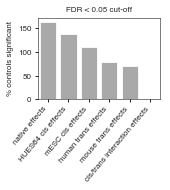

In [38]:
fig, ax = plt.subplots(figsize=(2.2, 1.5), nrows=1, ncols=1)

sns.barplot(data=n_sig_models, x="model", y="n_sig", color="darkgray", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("% controls significant")
_ = ax.set_xticklabels(n_sig_models["model"], rotation=50, ha="right", va="top")

ax.set_title("FDR < 0.05 cut-off")
fig.savefig("perc_ctrls_sig.05.pdf", dpi="figure", bbox_inches="tight")

now always cut off at the 10th percentile of FDRs of controls within a given model

In [39]:
NATIVE_THRESH = np.percentile(native_ctrls["fdr_native"], 5)
NATIVE_THRESH

4.785743473333633e-06

In [40]:
CIS_HUES64_THRESH = np.percentile(cis_HUES64_ctrls["fdr_cis_HUES64"], 5)
CIS_HUES64_THRESH

1.1036823366939007e-05

In [41]:
CIS_MESC_THRESH = np.percentile(cis_mESC_ctrls["fdr_cis_mESC"], 5)
CIS_MESC_THRESH

0.00012795164004255174

In [42]:
TRANS_HUMAN_THRESH = np.percentile(trans_human_ctrls["fdr_trans_human"], 5)
TRANS_HUMAN_THRESH

0.0030214066230191106

In [43]:
TRANS_MOUSE_THRESH = np.percentile(trans_mouse_ctrls["fdr_trans_mouse"], 5)
TRANS_MOUSE_THRESH

0.0055831050920595038

In [44]:
INT_THRESH = np.percentile(cis_trans_int_ctrls["fdr_int"], 5)
INT_THRESH

0.83616147958108622

now re-plot with threshold

In [45]:
n_sig_models = {}
for model, df, fdr, thresh in zip(["native effects", "HUES64 cis effects", "mESC cis effects", "human trans effects",
                                   "mouse trans effects", "cis/trans interaction effects"],
                                  [native_ctrls, cis_HUES64_ctrls, cis_mESC_ctrls, trans_human_ctrls, 
                                   trans_mouse_ctrls, cis_trans_int_ctrls],
                                  ["fdr_native", "fdr_cis_HUES64", "fdr_cis_mESC", "fdr_trans_human", 
                                   "fdr_trans_mouse", "fdr_int"],
                                  [NATIVE_THRESH, CIS_HUES64_THRESH, CIS_MESC_THRESH, TRANS_HUMAN_THRESH,
                                   TRANS_MOUSE_THRESH, 0.05]):
    n_sig = len(df[df[fdr] < thresh])
    n_sig_models[model] = [n_sig]
n_sig_models = pd.DataFrame.from_dict(n_sig_models, orient="index").reset_index()
n_sig_models.columns = ["model", "n_sig"]
n_sig_models

,model,n_sig
0,native effects,20
1,HUES64 cis effects,20
2,mESC cis effects,20
3,human trans effects,20
4,mouse trans effects,20
5,cis/trans interaction effects,0


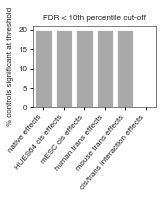

In [46]:
fig, ax = plt.subplots(figsize=(2.2, 1.5), nrows=1, ncols=1)

sns.barplot(data=n_sig_models, x="model", y="n_sig", color="darkgray", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("% controls significant at threshold")
_ = ax.set_xticklabels(n_sig_models["model"], rotation=50, ha="right", va="top")

ax.set_title("FDR < 10th percentile cut-off")
fig.savefig("perc_ctrls_sig.thresh.pdf", dpi="figure", bbox_inches="tight")

## 5. plot controls vs. TSSs for each model

control boxplots

5.68524376294e-40


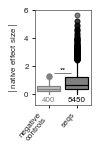

1.09333981908e-50


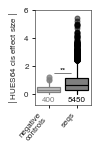

2.17909633261e-46


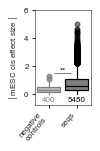

0.000663274721485


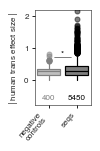

0.00117913773291


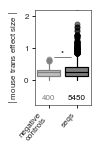

3.94444071884e-85


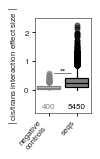

In [47]:
order = ["control", "TSS"]
pal = {"control": "gray", "TSS": "black"}

models = ["native", "HUES64 cis", "mESC cis", "human trans", "mouse trans", "cis/trans interaction"]
dfs = [native, HUES64_cis, mESC_cis, human_trans, mouse_trans, cis_trans_int]
logFCs = ["logFC_native", "logFC_cis_HUES64", "logFC_cis_mESC", "logFC_trans_human", "logFC_trans_mouse", "logFC_int"]
labels = ["native", "cis_HUES64", "cis_mESC", "trans_human", "trans_mouse", "cis_trans_int"]
ylims = [(-0.8, 6), (-0.8, 6), (-0.8, 6), (-0.8, 2.2), (-0.8, 2.2), (-0.8, 2.5)]
pxs = [(1.5, 1.4), (1.5, 1.4), (1.5, 1.4), (0.7, 0.7), (0.7, 0.7), (0.6, 0.5)]


for model, df, logFC, label, ylim, px in zip(models, dfs, logFCs, labels, ylims, pxs):
    df["is_ctrl"] = df.apply(is_ctrl, axis=1)
    df["abs_logFC"] = np.abs(df[logFC])
    
    fig = plt.figure(figsize=(1, 1.75))
    ax = sns.boxplot(data=df, x="is_ctrl", y="abs_logFC", flierprops = dict(marker='o', markersize=5), 
                     order=order, palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(["negative\ncontrols", "seqs"], rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel(r'$\vert$ %s effect size $\vert$' % model)

    for i, l in enumerate(order):
        n = len(df[df["is_ctrl"] == l])
        color = pal[l]
        ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)

    ax.set_ylim(ylim)

    # calc p-vals b/w dists
    dist1 = np.asarray(df[df["is_ctrl"] == "control"]["abs_logFC"])
    dist2 = np.asarray(df[df["is_ctrl"] != "control"]["abs_logFC"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]

    u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
    print(pval)

    annotate_pval(ax, 0.2, 0.8, px[0], 0, px[1], pval, fontsize)
    plt.show()
    fig.savefig("%s_ctrl_effectsize_boxplot.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

volcano plots

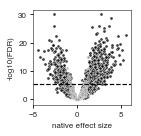

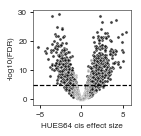

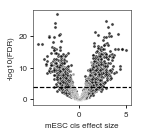

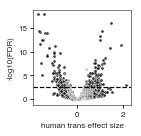

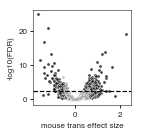

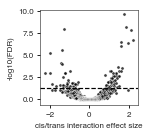

In [48]:
threshs = [NATIVE_THRESH, CIS_HUES64_THRESH, CIS_MESC_THRESH, TRANS_HUMAN_THRESH, TRANS_MOUSE_THRESH, 0.05]
fdrs = ["fdr_native", "fdr_cis_HUES64", "fdr_cis_mESC", "fdr_trans_human", "fdr_trans_mouse", "fdr_int"]

for model, df, logFC, fdr, label, thresh in zip(models, dfs, logFCs, fdrs, labels, threshs):
    df["is_ctrl"] = df.apply(is_ctrl, axis=1)
    
    neg_ctrls = df[df["is_ctrl"] == "control"]
    tss = df[df["is_ctrl"] != "control"]
    
    fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

    ax.scatter(tss[logFC], -np.log10(tss[fdr]), s=10, alpha=0.75, 
               color="black", linewidths=0.5, edgecolors="white")
    ax.scatter(neg_ctrls[logFC], -np.log10(neg_ctrls[fdr]), s=8, alpha=0.5, 
               color="gray", linewidths=0.5, edgecolors="white")

    plt.xlabel("%s effect size" % model)
    plt.ylabel("-log10(FDR)")
    ax.axhline(y=-np.log10(thresh), color="black", linestyle="dashed")

    plt.show()
    fig.savefig("%s_volcano.ctrls_highlighted.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

# controls > 0: 222, < 0: 178
# TSSs > 0: 3373, < 0: 2077


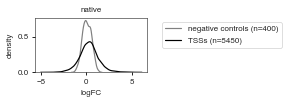

# controls > 0: 202, < 0: 198
# TSSs > 0: 2888, < 0: 2562


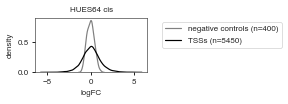

# controls > 0: 205, < 0: 195
# TSSs > 0: 2846, < 0: 2604


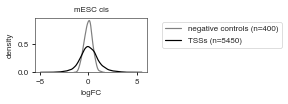

# controls > 0: 297, < 0: 103
# TSSs > 0: 4041, < 0: 1409


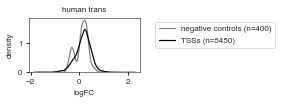

# controls > 0: 282, < 0: 118
# TSSs > 0: 4003, < 0: 1447


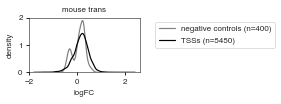

# controls > 0: 196, < 0: 204
# TSSs > 0: 2752, < 0: 2698


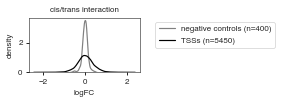

In [49]:
for model, df, logFC, fdr, label, thresh in zip(models, dfs, logFCs, fdrs, labels, threshs):
    df["is_ctrl"] = df.apply(is_ctrl, axis=1)
    
    neg_ctrls = df[df["is_ctrl"] == "control"]
    tss = df[df["is_ctrl"] != "control"]
    
    print("# controls > 0: %s, < 0: %s" % (len(neg_ctrls[neg_ctrls[logFC] > 0]), len(neg_ctrls[neg_ctrls[logFC] < 0])))
    print("# TSSs > 0: %s, < 0: %s" % (len(tss[tss[logFC] > 0]), len(tss[tss[logFC] < 0])))
    
    fig, ax = plt.subplots(figsize=(2, 1), nrows=1, ncols=1)
    
    sns.distplot(neg_ctrls[logFC], color="gray", label="negative controls (n=%s)" % len(neg_ctrls), hist=False, ax=ax)
    sns.distplot(tss[logFC], color="black", label="TSSs (n=%s)" % len(tss), hist=False, ax=ax) 
    
    ax.set_xlabel("logFC")
    ax.set_ylabel("density")
    ax.set_title(model)
    
    plt.legend(loc=2, bbox_to_anchor=(1.1, 1))
    
    plt.show()
    #fig.savefig("%s_ctrl_logFC.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

## 6. split result file indeces

In [50]:
native["hg19_id"] = native["index"].str.split("__", expand=True)[0]
native["biotype_hg19"] = native["index"].str.split("__", expand=True)[1]
native["mm9_id"] = native["index"].str.split("__", expand=True)[2]
native["biotype_mm9"] = native["index"].str.split("__", expand=True)[3]
native["tss_tile_num"] = native["index"].str.split("__", expand=True)[4]

In [51]:
HUES64_cis["hg19_id"] = HUES64_cis["index"].str.split("__", expand=True)[0]
HUES64_cis["biotype_hg19"] = HUES64_cis["index"].str.split("__", expand=True)[1]
HUES64_cis["mm9_id"] = HUES64_cis["index"].str.split("__", expand=True)[2]
HUES64_cis["biotype_mm9"] = HUES64_cis["index"].str.split("__", expand=True)[3]
HUES64_cis["tss_tile_num"] = HUES64_cis["index"].str.split("__", expand=True)[4]

In [52]:
mESC_cis["hg19_id"] = mESC_cis["index"].str.split("__", expand=True)[0]
mESC_cis["biotype_hg19"] = mESC_cis["index"].str.split("__", expand=True)[1]
mESC_cis["mm9_id"] = mESC_cis["index"].str.split("__", expand=True)[2]
mESC_cis["biotype_mm9"] = mESC_cis["index"].str.split("__", expand=True)[3]
mESC_cis["tss_tile_num"] = mESC_cis["index"].str.split("__", expand=True)[4]

In [53]:
human_trans["hg19_id"] = human_trans["index"].str.split("__", expand=True)[0]
human_trans["biotype_hg19"] = human_trans["index"].str.split("__", expand=True)[1]
human_trans["mm9_id"] = human_trans["index"].str.split("__", expand=True)[2]
human_trans["biotype_mm9"] = human_trans["index"].str.split("__", expand=True)[3]
human_trans["tss_tile_num"] = human_trans["index"].str.split("__", expand=True)[4]

In [54]:
mouse_trans["hg19_id"] = mouse_trans["index"].str.split("__", expand=True)[0]
mouse_trans["biotype_hg19"] = mouse_trans["index"].str.split("__", expand=True)[1]
mouse_trans["mm9_id"] = mouse_trans["index"].str.split("__", expand=True)[2]
mouse_trans["biotype_mm9"] = mouse_trans["index"].str.split("__", expand=True)[3]
mouse_trans["tss_tile_num"] = mouse_trans["index"].str.split("__", expand=True)[4]

In [55]:
cis_trans_int["hg19_id"] = cis_trans_int["index"].str.split("__", expand=True)[0]
cis_trans_int["biotype_hg19"] = cis_trans_int["index"].str.split("__", expand=True)[1]
cis_trans_int["mm9_id"] = cis_trans_int["index"].str.split("__", expand=True)[2]
cis_trans_int["biotype_mm9"] = cis_trans_int["index"].str.split("__", expand=True)[3]
cis_trans_int["tss_tile_num"] = cis_trans_int["index"].str.split("__", expand=True)[4]

## 7. merge result files w/ activity data

In [56]:
len(data)

4944

In [57]:
tmp = data.merge(native[["hg19_id", "mm9_id", "tss_tile_num", "logFC_native", "fdr_native"]], 
                 on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

5878

In [58]:
tmp = tmp.merge(HUES64_cis[["hg19_id", "mm9_id", "tss_tile_num", "logFC_cis_HUES64", "fdr_cis_HUES64"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

5878

In [59]:
tmp = tmp.merge(mESC_cis[["hg19_id", "mm9_id", "tss_tile_num", "logFC_cis_mESC", "fdr_cis_mESC"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

5878

In [60]:
tmp = tmp.merge(human_trans[["hg19_id", "mm9_id", "tss_tile_num", "logFC_trans_human", "fdr_trans_human"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

5878

In [61]:
tmp = tmp.merge(mouse_trans[["hg19_id", "mm9_id", "tss_tile_num", "logFC_trans_mouse", "fdr_trans_mouse"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

5878

In [62]:
tmp = tmp.merge(cis_trans_int[["hg19_id", "mm9_id", "tss_tile_num", "logFC_int", "fdr_int"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
print(len(tmp))
tmp.sample(5)

5878


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cleaner_biotype_hg19,minimal_biotype_hg19,cage_id_hg19,name_peak_hg19,stem_exp_hg19,mm9_id,...,logFC_cis_HUES64,fdr_cis_HUES64,logFC_cis_mESC,fdr_cis_mESC,logFC_trans_human,fdr_trans_human,logFC_trans_mouse,fdr_trans_mouse,logFC_int,fdr_int
3203,h.910,chr10,93558136.0,div_pc,div. mRNA,mRNA,"chr10:93558113..93558154,+",ENSG00000107854.5,6.21333,m.794,...,-0.160389,6.008244e-01,-0.065689,0.829383,-0.015055,0.961407,0.114289,0.690889,0.203731,0.951585
4683,h.3226,chr1,41386172.0,no cage activity,no CAGE activity,no CAGE activity,no cage activity,no cage activity,no cage activity,m.3037,...,1.440692,1.045391e-05,0.735895,0.029930,0.482458,0.100566,-0.392476,0.110535,-0.880272,0.202321
4991,h.244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,m.157,...,1.115080,4.355119e-05,0.826733,0.030879,0.292856,0.495698,0.145913,0.581138,-0.069449,0.987564
2475,h.3348,chr12,120876266.0,no cage activity,reclassified - CAGE peak,reclassified - CAGE peak,no cage activity,no cage activity,no cage activity,m.3158,...,0.116636,6.712372e-01,-0.260718,0.321138,0.239460,0.314977,-0.051933,0.873213,-0.193233,0.951585
3328,h.1338,chr1,205267902.0,enhancer,eRNA,eRNA,chr1:205267691-205267999,chr1:205267691-205267999__POSITIVE,0.11973099999999999,m.1020,...,-1.461224,7.993183e-07,-0.815343,0.003094,-0.172288,0.504651,0.414234,0.145922,0.536600,0.568832


In [63]:
data = tmp.copy()

In [64]:
data.columns

Index(['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19',
       'cleaner_biotype_hg19', 'minimal_biotype_hg19', 'cage_id_hg19',
       'name_peak_hg19', 'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9',
       'start_tss_mm9', 'biotype_mm9', 'cleaner_biotype_mm9',
       'minimal_biotype_mm9', 'cage_id_mm9', 'name_peak_mm9', 'stem_exp_mm9',
       'tss_tile_num', 'orig_species', 'biotype_switch_clean',
       'biotype_switch_minimal', 'HUES64_hg19', 'mESC_hg19', 'HUES64_mm9',
       'mESC_mm9', 'HUES64_padj_hg19', 'mESC_padj_hg19', 'HUES64_padj_mm9',
       'mESC_padj_mm9', 'logFC_native', 'fdr_native', 'logFC_cis_HUES64',
       'fdr_cis_HUES64', 'logFC_cis_mESC', 'fdr_cis_mESC', 'logFC_trans_human',
       'fdr_trans_human', 'logFC_trans_mouse', 'fdr_trans_mouse', 'logFC_int',
       'fdr_int'],
      dtype='object')

## 8. classify comparison effects as sig vs. not sig

In [65]:
data["native_status"] = data.apply(comp_status, fdr_col="fdr_native", thresh=NATIVE_THRESH, txt="native", axis=1)
data["cis_HUES64_status"] = data.apply(comp_status, fdr_col="fdr_cis_HUES64", thresh=CIS_HUES64_THRESH, 
                                       txt="cis", axis=1)
data["cis_mESC_status"] = data.apply(comp_status, fdr_col="fdr_cis_mESC", thresh=CIS_MESC_THRESH, txt="cis", axis=1)
data["trans_human_status"] = data.apply(comp_status, fdr_col="fdr_trans_human", thresh=TRANS_HUMAN_THRESH,
                                        txt="trans", axis=1)
data["trans_mouse_status"] = data.apply(comp_status, fdr_col="fdr_trans_mouse", thresh=TRANS_MOUSE_THRESH,
                                        txt="trans", axis=1)
data["cis_trans_int_status"] = data.apply(comp_status, fdr_col="fdr_int", thresh=0.05, txt="cis/trans int.", axis=1)

In [66]:
data.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cleaner_biotype_hg19,minimal_biotype_hg19,cage_id_hg19,name_peak_hg19,stem_exp_hg19,mm9_id,...,logFC_trans_mouse,fdr_trans_mouse,logFC_int,fdr_int,native_status,cis_HUES64_status,cis_mESC_status,trans_human_status,trans_mouse_status,cis_trans_int_status
5439,h.3180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,m.2991,...,0.169509,0.506366,-0.216789,0.923788,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
2588,h.3447,chr2,42274092.0,no cage activity,no CAGE activity,no CAGE activity,no cage activity,no cage activity,no cage activity,m.3257,...,-0.849076,0.000001,-0.302211,0.634118,significant native effect,no cis effect,significant cis effect,significant trans effect,significant trans effect,no cis/trans int. effect
400,h.549,chr11,60691945.0,div_pc,div. mRNA,mRNA,"chr11:60691924..60691966,+",ENSG00000006118.10,16.7378,m.435,...,-0.546316,0.019300,-0.250673,0.921933,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
1660,h.2329,chr14,67878950.0,protein_coding,mRNA,mRNA,"chr14:67878948..67878953,-",ENSG00000100558.4,0.10888900000000001,m.2141,...,0.528138,0.100329,0.219771,0.933031,significant native effect,significant cis effect,significant cis effect,significant trans effect,no trans effect,no cis/trans int. effect
5593,ctrl.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,samp.16,...,0.284013,0.313634,0.079607,0.987564,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect


## 9. compare l2fcs for elements called significant for each biotype & re-classify

In [67]:
min_order = ["no CAGE activity", "eRNA", "lncRNA", "mRNA", "other"]
palette = sns.husl_palette(n_colors=len(min_order))

0.716255932823


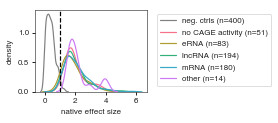

0.602908692744


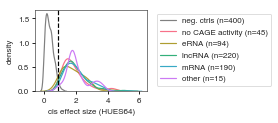

0.62366287214


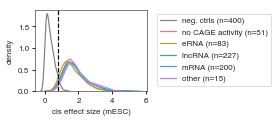

0.307736218191


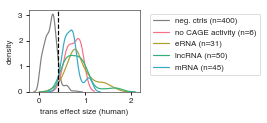

0.359630749904


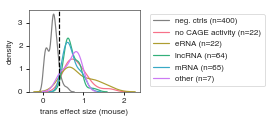

nan


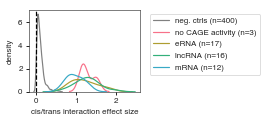

In [68]:
l2fc_cols = ["logFC_native", "logFC_cis_HUES64", "logFC_cis_mESC", "logFC_trans_human", "logFC_trans_mouse", 
             "logFC_int"]
sig_cols = ["native_status", "cis_HUES64_status", "cis_mESC_status", "trans_human_status", "trans_mouse_status",
            "cis_trans_int_status"]
xlabels = ["native effect size", "cis effect size (HUES64)", "cis effect size (mESC)", "trans effect size (human)",
           "trans effect size (mouse)", "cis/trans interaction effect size"]
xs = [1, 0.9, 0.8, 0.4, 0.4, 0]
min_vals = []

for l2fc_col, sig_col, xlabel, x in zip(l2fc_cols, sig_cols, xlabels, xs):
    
    fig, ax = plt.subplots(figsize=(2, 1.5), nrows=1, ncols=1)
    filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
    ctrls = np.abs(data[data["hg19_id"].str.contains("ctrl.")][l2fc_col])
    
    sig_ctrls = data[(data["hg19_id"].str.contains("ctrl.")) & (data[sig_col].str.contains("significant"))][l2fc_col]
    min_val = np.min(np.abs(sig_ctrls))
    print(min_val)
    min_vals.append(min_val)
    
    sns.distplot(ctrls, hist=False, color="gray", label="neg. ctrls (n=%s)" % len(ctrls), ax=ax)
    
    sub = filt[~filt[sig_col].str.contains("no ")]
    for i, label in enumerate(min_order):
        
        vals = np.abs(sub[sub["minimal_biotype_hg19"] == label][l2fc_col])
        sns.distplot(vals, hist=False, color=palette[i], label="%s (n=%s)" % (label, len(vals)), ax=ax)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel("density")
    ax.axvline(x=x, linestyle="dashed", color="black")
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
    plt.show()
    plt.close()

In [69]:
data.native_status.value_counts()

no native effect             4779
significant native effect    1099
Name: native_status, dtype: int64

In [70]:
data["native_status"] = data.apply(comp_status_stringent, status_col="native_status", 
                                   l2fc_col="logFC_native", l2fc_thresh=min_vals[0], txt="native", axis=1)
data["cis_HUES64_status"] = data.apply(comp_status_stringent, status_col="cis_HUES64_status",  
                                       l2fc_col="logFC_cis_HUES64", l2fc_thresh=min_vals[1], txt="cis", axis=1)
data["cis_mESC_status"] = data.apply(comp_status_stringent, status_col="cis_mESC_status", 
                                     l2fc_col="logFC_cis_mESC", l2fc_thresh=min_vals[2], txt="cis", axis=1)
data["trans_human_status"] = data.apply(comp_status_stringent, status_col="trans_human_status", 
                                        l2fc_col="logFC_trans_human", l2fc_thresh=min_vals[3], txt="trans", axis=1)
data["trans_mouse_status"] = data.apply(comp_status_stringent, status_col="trans_mouse_status", 
                                        l2fc_col="logFC_trans_mouse", l2fc_thresh=min_vals[4], txt="trans", axis=1)
data["cis_trans_int_status"] = data.apply(comp_status_stringent, status_col="cis_trans_int_status", 
                                          l2fc_col="logFC_int", l2fc_thresh=0, txt="cis/trans int.", axis=1)

In [71]:
data.native_status.value_counts()

no native effect             4782
significant native effect    1096
Name: native_status, dtype: int64

## 9. classify effects as higher in mouse or human

In [72]:
data["native_status_det"] = data.apply(comp_status_detail, status_col="native_status",
                                       logFC_col="logFC_native", txt="native", axis=1)
data["cis_HUES64_status_det"] = data.apply(comp_status_detail, status_col="cis_HUES64_status",
                                           logFC_col="logFC_cis_HUES64", txt="cis", axis=1)
data["cis_mESC_status_det"] = data.apply(comp_status_detail, status_col="cis_mESC_status",
                                         logFC_col="logFC_cis_mESC", txt="cis", axis=1)
data["trans_human_status_det"] = data.apply(comp_status_detail, status_col="trans_human_status",
                                            logFC_col="logFC_trans_human", txt="trans", axis=1)
data["trans_mouse_status_det"] = data.apply(comp_status_detail, status_col="trans_mouse_status",
                                            logFC_col="logFC_trans_mouse", txt="trans", axis=1)
data["cis_trans_int_status_det"] = data.apply(comp_status_detail, status_col="cis_trans_int_status", 
                                              logFC_col="logFC_int", txt="cis/trans int.", axis=1)

In [73]:
data.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cleaner_biotype_hg19,minimal_biotype_hg19,cage_id_hg19,name_peak_hg19,stem_exp_hg19,mm9_id,...,cis_mESC_status,trans_human_status,trans_mouse_status,cis_trans_int_status,native_status_det,cis_HUES64_status_det,cis_mESC_status_det,trans_human_status_det,trans_mouse_status_det,cis_trans_int_status_det
2968,h.463,chr3,31745461.0,antisense_upep,other lncRNA,lncRNA,"chr3:31745457..31745467,+",ENSG00000232490.2,0.0,m.3488,...,no cis effect,no trans effect,no trans effect,no cis/trans int. effect,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
1763,h.2418,chr17,59532466.0,enhancer,eRNA,eRNA,chr17:59532462-59532698,chr17:59532462-59532698__NEGATIVE,0.0558899,m.2230,...,no cis effect,no trans effect,no trans effect,no cis/trans int. effect,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
365,h.492,chr6,13615570.0,div_pc,div. mRNA,mRNA,"chr6:13615554..13615601,+",ENSG00000225921.2,148.999,m.378,...,no cis effect,no trans effect,no trans effect,no cis/trans int. effect,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
4464,h.2858,chr6,82956800.0,no cage activity,no CAGE activity,no CAGE activity,no cage activity,no cage activity,no cage activity,m.2669,...,no cis effect,no trans effect,no trans effect,no cis/trans int. effect,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
4615,h.3128,chr15,93362113.0,no cage activity,no CAGE activity,no CAGE activity,no cage activity,no cage activity,no cage activity,m.2939,...,no cis effect,no trans effect,no trans effect,no cis/trans int. effect,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect


## 10. classify cis & trans effects into one effect (since we measured in 2 contexts)

In [74]:
data["cis_status_one"] = data.apply(comp_status_one, status_col1="cis_HUES64_status", 
                                    status_col2="cis_mESC_status", txt="cis", axis=1)
data["trans_status_one"] = data.apply(comp_status_one, status_col1="trans_human_status", 
                                      status_col2="trans_mouse_status", txt="trans", axis=1)

In [75]:
data["cis_status_det_one"] = data.apply(comp_status_detail_one, status_col1="cis_HUES64_status", 
                                        status_col2="cis_mESC_status", logFC_col1="logFC_cis_HUES64", 
                                        logFC_col2="logFC_cis_mESC", txt="cis", axis=1)
data["trans_status_det_one"] = data.apply(comp_status_detail_one, status_col1="trans_human_status", 
                                          status_col2="trans_mouse_status", logFC_col1="logFC_trans_human", 
                                          logFC_col2="logFC_trans_mouse", txt="trans", axis=1)

In [76]:
data["logFC_cis_one"] = data.apply(comp_logFC_one, status_col1="cis_HUES64_status", status_col2="cis_mESC_status",
                                   logFC_col1="logFC_cis_HUES64", logFC_col2="logFC_cis_mESC", axis=1)
data["logFC_trans_one"] = data.apply(comp_logFC_one, status_col1="trans_human_status", status_col2="trans_mouse_status",
                                     logFC_col1="logFC_trans_human", logFC_col2="logFC_trans_mouse", axis=1)

## 11. print numbers with each effect

In [77]:
# remove ctrls
data = data[~data["hg19_id"].str.contains("ctrl")]
len(data)

5478

## native

In [78]:
data.native_status.value_counts()

no native effect             4401
significant native effect    1077
Name: native_status, dtype: int64

## cis - HUES64

In [79]:
data.cis_HUES64_status.value_counts()

no cis effect             4299
significant cis effect    1179
Name: cis_HUES64_status, dtype: int64

## cis - mESC

In [80]:
data.cis_mESC_status.value_counts()

no cis effect             4344
significant cis effect    1134
Name: cis_mESC_status, dtype: int64

## trans - human

In [81]:
data.trans_human_status.value_counts()

no trans effect             5242
significant trans effect     236
Name: trans_human_status, dtype: int64

## trans - mouse

In [82]:
data.trans_mouse_status.value_counts()

no trans effect             5153
significant trans effect     325
Name: trans_mouse_status, dtype: int64

## cis/trans interactions

In [83]:
data.cis_trans_int_status.value_counts()

no cis/trans int. effect             5388
significant cis/trans int. effect      90
Name: cis_trans_int_status, dtype: int64

In [84]:
np.max(np.abs(data[data["trans_mouse_status"].str.contains("significant")]["fdr_trans_mouse"]))

0.0055205927634228704

## 12. write files

In [85]:
# rearrange columns for readability
data = data[['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19', 'cage_id_hg19', 'name_peak_hg19', 
             'cleaner_biotype_hg19', 'minimal_biotype_hg19', 'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9', 
             'start_tss_mm9', 'biotype_mm9', 'cage_id_mm9', 'name_peak_mm9', 'cleaner_biotype_mm9', 
             'minimal_biotype_mm9', 'stem_exp_mm9', 'tss_tile_num', 'orig_species', 'biotype_switch_clean', 
             'biotype_switch_minimal', 'HUES64_hg19', 'mESC_hg19', 'HUES64_mm9', 'mESC_mm9', 'HUES64_padj_hg19', 
             'mESC_padj_hg19', 'HUES64_padj_mm9', 'mESC_padj_mm9', 'logFC_native', 'fdr_native', 'native_status', 
             'native_status_det', 'logFC_cis_HUES64', 'fdr_cis_HUES64', 'logFC_cis_mESC', 'fdr_cis_mESC',  
             'cis_HUES64_status', 'cis_mESC_status', 'cis_HUES64_status_det', 'cis_mESC_status_det', 'cis_status_one', 
             'cis_status_det_one', 'logFC_cis_one', 'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse', 
             'fdr_trans_mouse', 'trans_human_status', 'trans_mouse_status', 'trans_human_status_det', 
             'trans_mouse_status_det',  'trans_status_one', 'trans_status_det_one', 'logFC_trans_one',  'logFC_int', 
             'fdr_int', 'cis_trans_int_status', 'cis_trans_int_status_det']]

In [86]:
len(data)

5478

In [87]:
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,cleaner_biotype_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,div_lnc,"chr1:2985420..2985438,-",ENSG00000177133.6,div. lncRNA,lncRNA,0.07111110000000001,m.1,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,div_lnc,"chr1:8086546..8086571,+",ENSG00000238290.1,div. lncRNA,lncRNA,0.10444400000000001,m.2,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense_upep,"chr1:26498321..26498327,-",ENSG00000236782.1,other lncRNA,lncRNA,0.03,m.3,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lincRNA,lncRNA,0.841111,m.4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lincRNA,lncRNA,0.116667,m.4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect


In [88]:
data.to_csv("../../../data/02__mpra/03__results/all_processed_results.txt", sep="\t", index=False)